<a href="https://colab.research.google.com/github/leeliangchao/-spatiotemporal-pedict/blob/main/7%E5%A4%A92%E5%A4%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

In [3]:
# !pip install mlxtend==0.18
# from mlxtend.plotting import heatmap


## 范围选择

In [4]:
Longitude_Index = 54    #经度索引
Longitude_End = 62 +1   #经度索引

Latitude_Index = 17  # 纬度索引
Latitude_End = 31 +1 # 纬度索引

In [5]:
Sample = np.load('/content/drive/MyDrive/TEC/日本3台站/CODE/TEC.npy')

In [6]:
Sample.shape

(71, 73, 25, 366, 1)

In [8]:
Target_region = Sample[Latitude_Index:Latitude_End, Longitude_Index:Longitude_End,:,:,:]

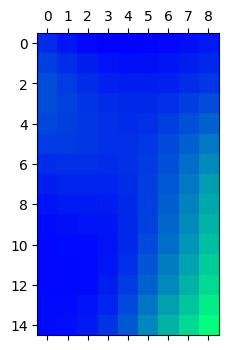

matplotlib.image.AxesImage

In [9]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
line=ax.matshow(Target_region[:,:,-2,0,0], cmap = plt.cm.winter)
plt.show()
type(line)

In [10]:
from matplotlib import animation

In [11]:
def animate(i):
  line.set_data(Target_region[:,:,i,0,0])
  return line,
def init():
  line.set_data(Target_region[:,:,0,0,0])
  return line,
ani = animation.FuncAnimation(fig=fig, func=animate,frames=25,init_func=init,interval=200,blit=False)
ani.save('ani.gif', writer='pillow')
plt.show()

### 样本制作

In [12]:
###################绘图###################
import matplotlib.pyplot as plt
###################标准化###################
from sklearn.preprocessing import MinMaxScaler

In [13]:
Target_region.shape

(15, 9, 25, 366, 1)

In [14]:
data = np.swapaxes(Target_region, 0,2)
data = np.swapaxes(data, 1,3)
data = np.swapaxes(data, 0,1)

In [15]:
data.shape

(366, 25, 15, 9, 1)

In [16]:
data = np.delete(data,[-1], axis=0);data.shape

(365, 25, 15, 9, 1)

In [17]:
data = data.reshape(-1,15,9,1)

In [18]:
data.shape

(9125, 15, 9, 1)

In [19]:
data = data[::2]

In [20]:
data.shape

(4563, 15, 9, 1)

In [21]:
# 数据集划分
def create_dataset(data, look_back=91, forward=26):
  x = []
  y = []
  for i in range(0,data.shape[0]-(look_back+forward)+1,forward):
    x.append(data[i:i+look_back,:,:,:])
    y.append(data[i+look_back:i+look_back+forward,:,:,:])
  return (np.array(x), np.array(y))


In [22]:
a,b = create_dataset(data)

In [23]:
a.shape,b.shape

((172, 91, 15, 9, 1), (172, 26, 15, 9, 1))

In [24]:
# len(df)为df多少行
pot = round(0.8 * a.shape[0])
pot

138

In [25]:
x_train, y_train = a[:pot],b[:pot]
x_test, y_test = a[pot:],b[pot:]
# y_train = np.expand_dims(y_train, 1)
# y_test = np.expand_dims(y_test, 1)

In [26]:
x_train.shape, x_test.shape,y_test.shape

((138, 91, 15, 9, 1), (34, 91, 15, 9, 1), (34, 26, 15, 9, 1))

### LearningRateScheduler调整学习率

In [27]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [29]:
def scheduler(epoch):
    if epoch % 40 ==0 and epoch != 0 :
        lr = K.get_value(tcn.optimizer.lr)
        if lr > 1e-5:
            K.set_value(tcn.optimizer.lr, lr *0.5)
            print('lr changed to {}'.format(lr * 0.5))
    return K.get_value(tcn.optimizer.lr)

In [30]:
reduce_lr = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='loss', 
                               patience=20, 
                               min_delta=1e-5,
                               mode='auto',
                               restore_best_weights=False,#是否从具有监测数量的最佳值的时期恢复模型权重
                               verbose=2)

In [31]:
import tensorflow as tf
from tensorflow.keras.layers import ConvLSTM2D,Conv2D,Conv3D,BatchNormalization,Flatten,RepeatVector,Reshape
from tensorflow.keras import Input, Model, Sequential
from sklearn.metrics import mean_squared_error

In [32]:
# 自定义损失函数
def my_metric_fn(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
# Loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0, filter_size=3))

In [33]:
#输入维数
tcn = Sequential()
input_layer =Input(shape=(x_train.shape[1:]))
tcn.add(input_layer)
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(3,3),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=False
    )
)
tcn.add(BatchNormalization())
# ###############################
tcn.add(Flatten())
tcn.add(RepeatVector(13*2))
tcn.add(Reshape((13*2,15,9,32)))
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
tcn.add(
    ConvLSTM2D(
        filters=32,
        kernel_size=(2,2),
        padding='same',
        return_sequences=True
    )
)
tcn.add(BatchNormalization())
# tcn.add(LayerNormalization())
tcn.add(Conv3D(filters=1, kernel_size=(3,3,3),activation="linear", padding="same"))
tcn.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss=root_mean_squared_error)# RMSE
tcn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 91, 15, 9, 32)     38144     
                                                                 
 batch_normalization (BatchN  (None, 91, 15, 9, 32)    128       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 91, 15, 9, 32)     32896     
                                                                 
 batch_normalization_1 (Batc  (None, 91, 15, 9, 32)    128       
 hNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 91, 15, 9, 32)     32896     
                                                                 
 batch_normalization_2 (Batc  (None, 91, 15, 9, 32)    1

In [35]:
history=tcn.fit(x_train,y_train, 
        epochs=121, batch_size=64,validation_data=[x_test, y_test], callbacks=[reduce_lr])


Epoch 1/121
3/3 [==============================] - 7s 2s/step - loss: 3.0372 - val_loss: 3.8440 - lr: 0.0012
Epoch 2/121
3/3 [==============================] - 7s 2s/step - loss: 2.9601 - val_loss: 3.6012 - lr: 0.0012
Epoch 3/121
3/3 [==============================] - 7s 2s/step - loss: 3.0137 - val_loss: 3.3866 - lr: 0.0012
Epoch 4/121
3/3 [==============================] - 7s 2s/step - loss: 3.0033 - val_loss: 3.4266 - lr: 0.0012
Epoch 5/121
3/3 [==============================] - 7s 2s/step - loss: 2.9659 - val_loss: 3.4122 - lr: 0.0012
Epoch 6/121
3/3 [==============================] - 7s 2s/step - loss: 2.9686 - val_loss: 3.2925 - lr: 0.0012
Epoch 7/121
3/3 [==============================] - 9s 3s/step - loss: 2.9460 - val_loss: 3.4238 - lr: 0.0012
Epoch 8/121
3/3 [==============================] - 7s 2s/step - loss: 2.8694 - val_loss: 3.3929 - lr: 0.0012
Epoch 9/121
3/3 [==============================] - 7s 2s/step - loss: 2.8590 - val_loss: 3.8871 - lr: 0.0012
Epoch 10/121
3/3 [=

In [ ]:
# history.history.keys() #查看history中存储了哪些参数

In [ ]:
# plt.plot(history.epoch,history.history.get('my_metric_fn')[:]) #画出随着epoch增大loss的变化图
#plt.plot(history.epoch,history.history.get('acc'))#画出随着epoch增大准确率的变化图

In [ ]:
# plt.plot(history.epoch, history.history.get('lr'))

In [ ]:
# from tensorflow.keras.models import load_model
# tcn = load_model('/content/7d2d.h5',custom_objects={'root_mean_squared_error':root_mean_squared_error})

In [36]:
tcn.evaluate(x_test, y_test)

2/2 [==============================] - 1s 279ms/step - loss: 2.1573


2.1572768688201904

In [37]:
predict = tcn.predict(x_test)

2/2 [==============================] - 2s 227ms/step


In [38]:
predict.shape

(34, 26, 15, 9, 1)

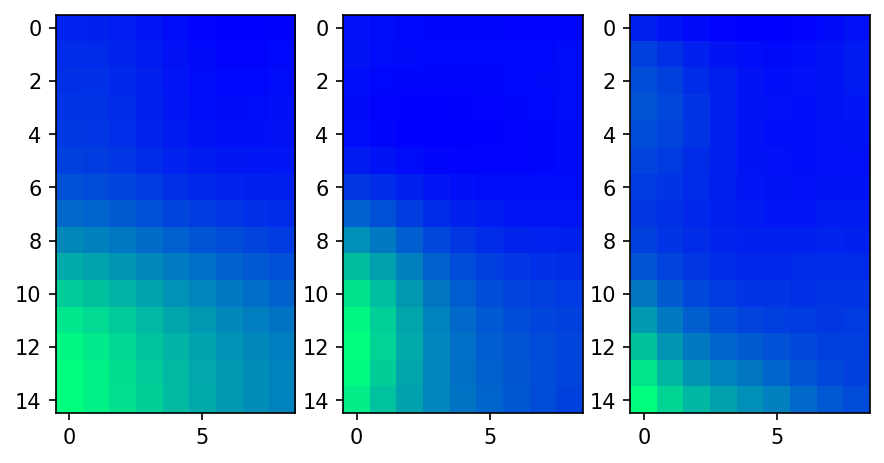

In [39]:
#@title
test_day = 1

fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(y_test[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(y_test[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(y_test[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(y_test[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(y_test[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(y_test[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(y_test[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(y_test[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(y_test[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(y_test[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(y_test[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(y_test[test_day,11,:,:,0], cmap = plt.cm.winter)

# plt.colorbar(im1)

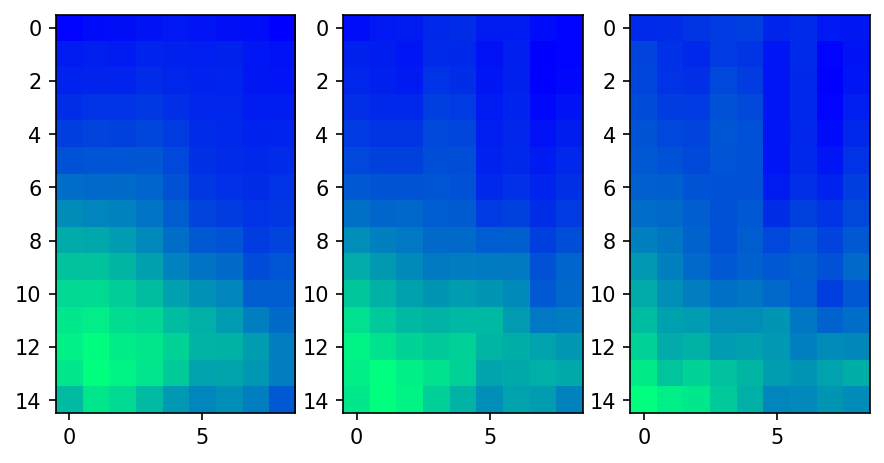

In [40]:
#@title
fig, ax = plt.subplots(1,3,figsize=(7,7),dpi=150)

im1 = ax[0].imshow(predict[test_day,0,:,:,0], cmap = plt.cm.winter)
im1 = ax[1].imshow(predict[test_day,1,:,:,0], cmap = plt.cm.winter)
im1 = ax[2].imshow(predict[test_day,2,:,:,0], cmap = plt.cm.winter)

# im1 = ax[1][0].imshow(predict[test_day,3,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][1].imshow(predict[test_day,4,:,:,0], cmap = plt.cm.winter)
# im1 = ax[1][2].imshow(predict[test_day,5,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][0].imshow(predict[test_day,6,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][1].imshow(predict[test_day,7,:,:,0], cmap = plt.cm.winter)
# im1 = ax[2][2].imshow(predict[test_day,8,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][0].imshow(predict[test_day,9,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][1].imshow(predict[test_day,10,:,:,0], cmap = plt.cm.winter)
# im1 = ax[3][2].imshow(predict[test_day,11,:,:,0], cmap = plt.cm.winter)

In [54]:
tcn.save('7d2d_j.h5')

### RMSE计算

In [41]:
from sklearn.metrics import mean_squared_error

In [42]:
P = predict
P = P.reshape(-1,1)
P.shape

(119340, 1)

In [43]:
R = y_test
R = R.reshape(-1,1)
R.shape

(119340, 1)

In [44]:
mean_squared_error(R, P, squared=False)

2.159083138158945

### 计算$R^{2}$

In [45]:
from sklearn.metrics import r2_score

In [46]:
r2 = round(r2_score(P, R),4)
r2

0.8547

### 算相对误差直方图

Text(0.5, 0, 'Residual(TECU)')

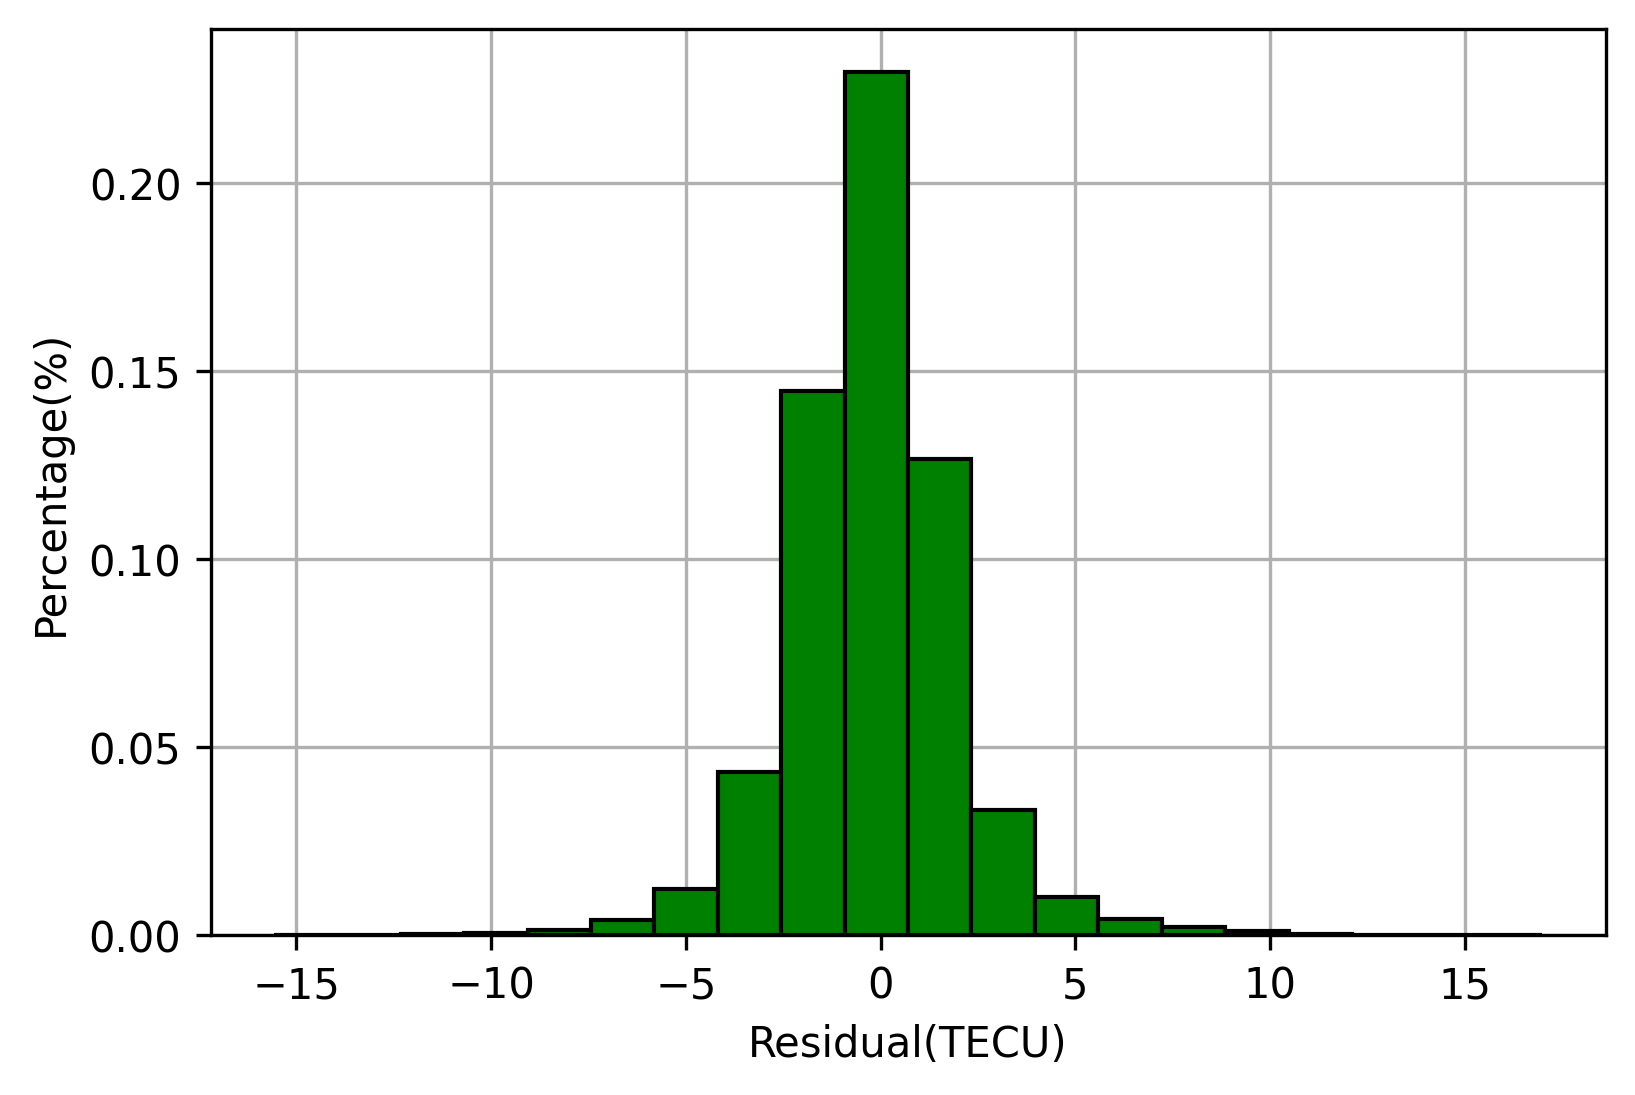

In [47]:
PD = (R-P)
fig, ax = plt.subplots(dpi=300)
ax.grid(True, zorder=1)
ax.hist(PD, bins=20, density=True, edgecolor='k',color='g',zorder=2)

ax.set_ylabel("Percentage(%)")
ax.set_xlabel("Residual(TECU)")

### 计算预测显示的散点图

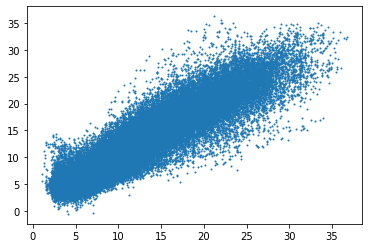

In [48]:
plt.scatter(R,P, s=1)

In [49]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(R, P)

reg.coef_, reg.intercept_

(array([[0.90268102]]), array([1.10378337]))

In [50]:
line_x = np.linspace(0, 30, 2)
y = reg.coef_[0][0] * line_x + reg.intercept_[0]
y

array([ 1.10378337, 28.18421394])

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde

In [53]:
P.shape

(119340, 1)

In [ ]:
fig, ax = plt.subplots(dpi=300) 
R = np.squeeze(R[:])
P = np.squeeze(P[:])
xy = np.vstack([R,P])
z = gaussian_kde(xy)(xy)
idx = z.argsort()
R,P,z = R[idx],P[idx],z[idx]
scatter = ax.scatter(R,P,s=5,c=z,marker='o',edgecolors='',cmap='Spectral')
ax.set_xlim(0,30)
ax.set_ylim(0,30)
plt.xlabel('Observed TEC/TECU', fontsize=14)
plt.ylabel('Forecast TEC/TECU', fontsize=14)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax, label='frequency')

ax.plot(line_x, y, 'k')
# # # plt.text(100, 40, r'$k_a$', fontsize=18)

ax.text(20,5, 'R:{}\nK:{}'.format(r2, round(reg.coef_[0][0],4)))